# Overview

The goal of this lab is to develop and operationalize a predictive maintenance machine learning solution. 

The lab is based on a predictive maintenance use case from the energy industry but the key concepts and solution patterns generalize well to other use cases and industries.

The input data are simulated (and simplified) telemetry and machine log readings from a hydropower turbine.

The goal of the lab is to create a binary classification model that can predict the turbine failure. Specifically, whether the turbine will experience a component failure in the 24 hours following the given telemetry and error reading.

The lab consists of 4 instructor faciliated exercises:
- Exercise 1 - Data Exploration. 
- Exercise 2 - Feature Enginnering.
- Exercise 3 - Model Development and Evaluation
- Exercise 4 - Model Deployment


# Exercise 1 - Data Exploration

## Data Sources


The data for the labs comes from 4 different sources which are: 
- real-time telemetry data collected from machines, 
- error messages, 
- failure history and,
- machine information such as type and age. 


In [1]:
# Environment Setup
library("AzureML") # Connect to Azure Machine Learning

library("dplyr") # Data munging functions
library("zoo")   # Feature engineering rolling aggregates

library("data.table") # Feature engineering

library("ggplot2") # Graphics
library("scales") # For time formatted axis

# connect to the workspace
ws <- workspace()

# load datasets
telemetry <- download.datasets(ws, name = "telemetry")
errors <- download.datasets(ws, name = "errors")
machines <- download.datasets(ws, name = "machines")
failures <- download.datasets(ws, name = "failures")




Attaching package: 'dplyr'

The following object is masked from 'package:stats':

    filter

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, last



### Telemetry

The first data source is the telemetry time-series data which consists of voltage, rotation, pressure and vibration measurements collected from 100 machines in real time averaged over every hour collected during the year 2015. Below, we provide first 10 records of the first machine with machineID=1. A summary of the whole dataset is also provided.

In [2]:

# format datetime field which comes in as.character
telemetry$datetime <- as.POSIXct(telemetry$datetime,
                                 format="%m/%d/%Y %I:%M:%S %p",
                                 tz="UTC")

cat("Total Number of telemetry records:", nrow(telemetry))
range(telemetry$datetime)
head(telemetry,10)
tail(telemetry,10)
summary(telemetry)


Total Number of telemetry records: 876100

[1] "2015-01-01 06:00:00 UTC" "2016-01-01 06:00:00 UTC"

datetime,machineID,volt,rotate,pressure,vibration
2015-01-01 06:00:00,1,176.2179,418.5041,113.07794,45.08769
2015-01-01 07:00:00,1,162.8792,402.7475,95.46053,43.41397
2015-01-01 08:00:00,1,170.9899,527.3498,75.23790,34.17885
2015-01-01 09:00:00,1,162.4628,346.1493,109.24856,41.12214
2015-01-01 10:00:00,1,157.6100,435.3769,111.88665,25.99051
2015-01-01 11:00:00,1,172.5048,430.3234,95.92704,35.65502
2015-01-01 12:00:00,1,156.5560,499.0716,111.75568,42.75392
2015-01-01 13:00:00,1,172.5228,409.6247,101.00108,35.48201
2015-01-01 14:00:00,1,175.3245,398.6488,110.62436,45.48229
2015-01-01 15:00:00,1,169.2184,460.8507,104.84823,39.90174


,datetime,machineID,volt,rotate,pressure,vibration
876091,2015-12-31 21:00:00,100,153.4046,552.0126,99.13295,37.66681
876092,2015-12-31 22:00:00,100,169.3973,546.1446,107.60703,38.69560
876093,2015-12-31 23:00:00,100,152.1820,414.0116,117.42634,43.96671
876094,2016-01-01 00:00:00,100,168.7400,439.4841,103.15823,47.28900
876095,2016-01-01 01:00:00,100,162.7427,481.2539,101.58973,44.38275
876096,2016-01-01 02:00:00,100,179.4382,395.2228,102.29071,50.77194
876097,2016-01-01 03:00:00,100,189.6176,446.2080,98.18061,35.12307
876098,2016-01-01 04:00:00,100,192.4834,447.8165,94.13284,48.31456
876099,2016-01-01 05:00:00,100,165.4753,413.7717,104.08107,44.83526
876100,2016-01-01 06:00:00,100,171.3360,496.0969,79.09554,37.84525


    datetime                     machineID           volt       
 Min.   :2015-01-01 06:00:00   Min.   :  1.00   Min.   : 97.33  
 1st Qu.:2015-04-02 12:00:00   1st Qu.: 25.75   1st Qu.:160.30  
 Median :2015-07-02 18:00:00   Median : 50.50   Median :170.61  
 Mean   :2015-07-02 18:00:00   Mean   : 50.50   Mean   :170.78  
 3rd Qu.:2015-10-02 00:00:00   3rd Qu.: 75.25   3rd Qu.:181.00  
 Max.   :2016-01-01 06:00:00   Max.   :100.00   Max.   :255.12  
     rotate         pressure        vibration    
 Min.   :138.4   Min.   : 51.24   Min.   :14.88  
 1st Qu.:412.3   1st Qu.: 93.50   1st Qu.:36.78  
 Median :447.6   Median :100.43   Median :40.24  
 Mean   :446.6   Mean   :100.86   Mean   :40.39  
 3rd Qu.:482.2   3rd Qu.:107.56   3rd Qu.:43.78  
 Max.   :695.0   Max.   :185.95   Max.   :76.79  

As an example, below is a plot of voltage values for two machineIDs for January 2015.

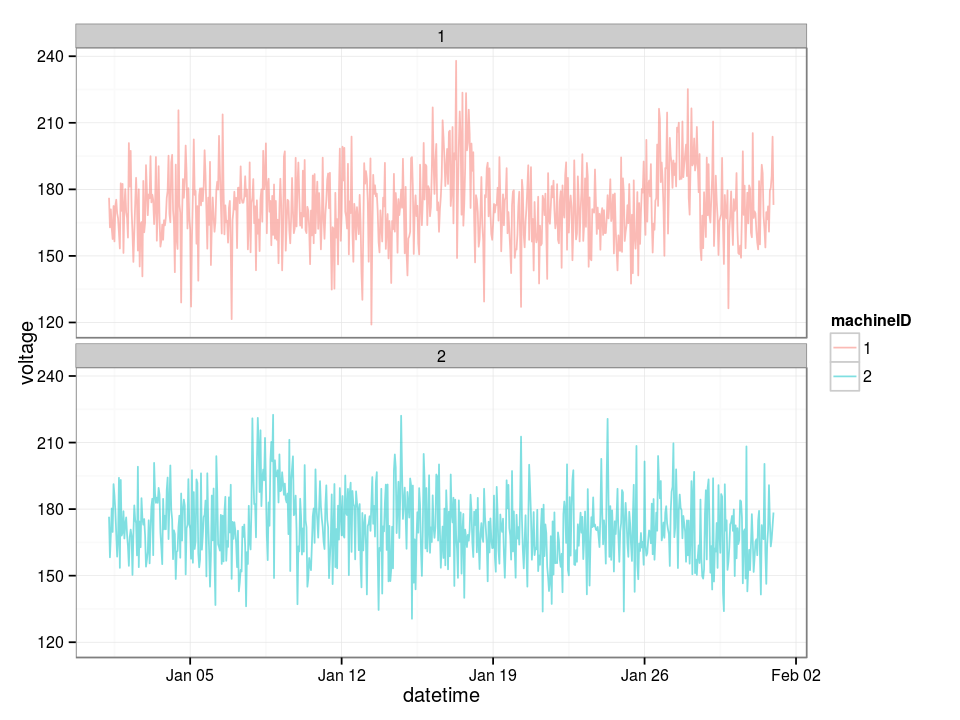

In [3]:
theme_set(theme_bw())  # theme for figures
options(repr.plot.width = 8, repr.plot.height = 6)

ggplot(data = telemetry %>% filter(machineID %in% 1:2, 
                                 datetime > as.POSIXct("2015-01-01"),
                                 datetime < as.POSIXct("2015-02-01")),
       aes(x = datetime, y = volt, col = factor(machineID))) +
  geom_line(alpha = 0.5) +
  labs(y = "voltage", color = "machineID") +
  facet_wrap(~machineID, ncol=1)


### Errors

The second major data source is the error logs. These are non-breaking errors thrown while the machine is still operational and do not constitute as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

In [4]:

# format datetime and errorID fields
errors$datetime <- as.POSIXct(errors$datetime,
                              format="%m/%d/%Y %I:%M:%S %p", 
                              tz="UTC")
errors$errorID <- as.factor(errors$errorID)

cat("Total Number of error records:",nrow(errors))
errors[c(1:5, nrow(errors)-4:1),]

Total Number of error records: 3919

,datetime,machineID,errorID
1,2015-01-03 07:00:00,1,error1
2,2015-01-03 20:00:00,1,error3
3,2015-01-04 06:00:00,1,error5
4,2015-01-10 15:00:00,1,error4
5,2015-01-22 10:00:00,1,error4
3915,2015-11-21 08:00:00,100,error2
3916,2015-12-04 02:00:00,100,error1
3917,2015-12-08 06:00:00,100,error2
3918,2015-12-08 06:00:00,100,error3


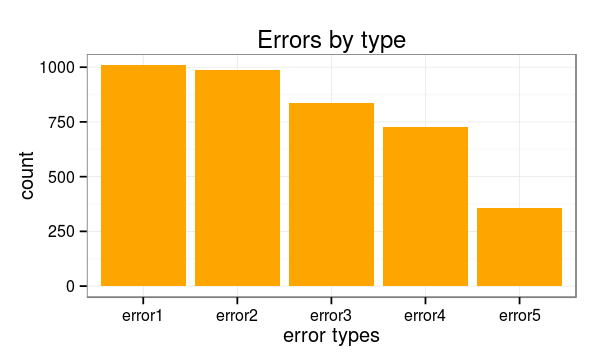

In [5]:
options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(errors, aes(x = errorID)) + 
    geom_histogram(fill = "orange") + 
    labs(title = "Errors by type", x = "error types")

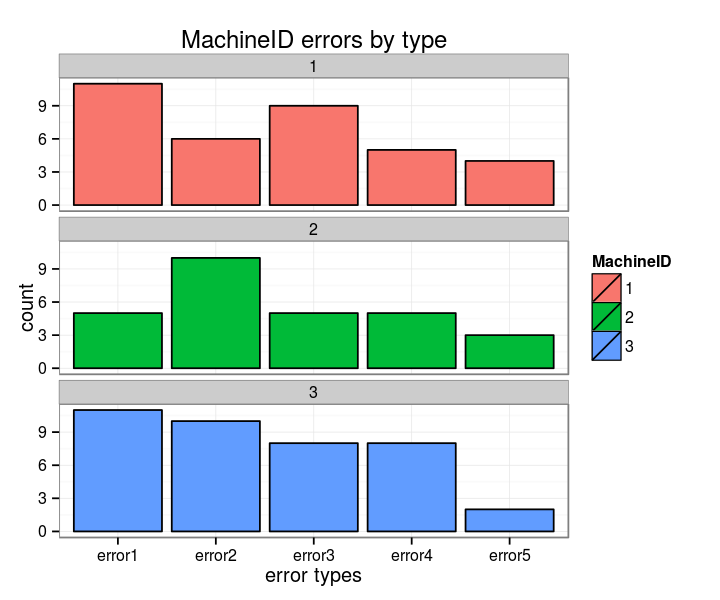

In [6]:
options(repr.plot.width = 6, repr.plot.height = 5)
ggplot(errors %>% filter(machineID < 4), 
       aes(x = errorID, fill = factor(machineID))) + 
    geom_histogram(color = "black") + 
    labs(title = "MachineID errors by type", x = "error types", fill="MachineID")+
    facet_wrap(~machineID, ncol = 1)

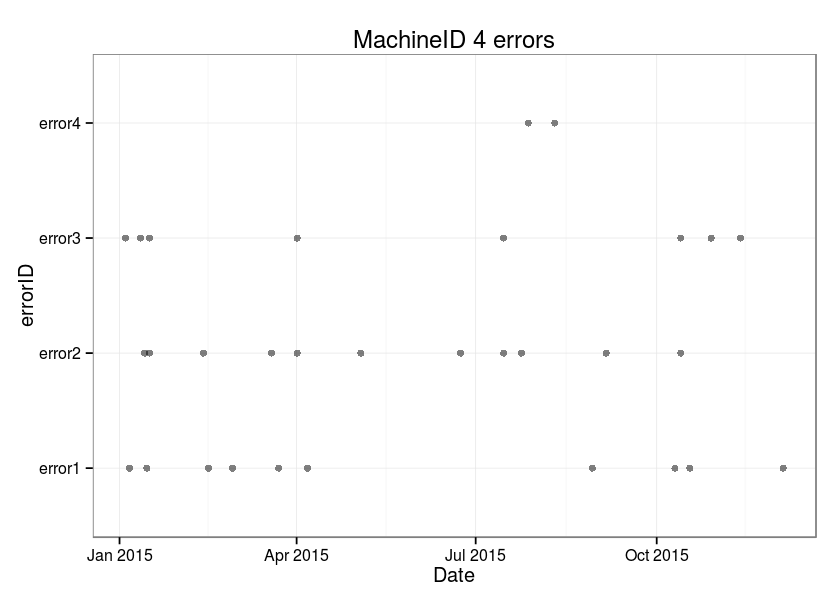

In [7]:
options(repr.plot.width = 7, repr.plot.height = 5)
ggplot(errors %>% filter(machineID == 4), 
       aes(y = errorID, x = datetime)) + 
    geom_point(color = "black", alpha = 0.5) + 
    labs(title = "MachineID 4 errors", x = "Date")

### Machines

This data set includes some information about the machines which are model type and age which is years in service.

In [8]:

# format model field
machines$model <- as.factor(machines$model)

cat("Total number of machines:", nrow(machines))
machines[c(1:5, nrow(machines)-4:0),]
summary(machines)

Total number of machines: 100

,machineID,model,age
1,1,model3,18
2,2,model4,7
3,3,model3,8
4,4,model3,7
5,5,model3,2
96,96,model2,10
97,97,model2,14
98,98,model2,20
99,99,model1,14
100,100,model4,5


   machineID         model         age       
 Min.   :  1.00   model1:16   Min.   : 0.00  
 1st Qu.: 25.75   model2:17   1st Qu.: 6.75  
 Median : 50.50   model3:35   Median :12.00  
 Mean   : 50.50   model4:32   Mean   :11.33  
 3rd Qu.: 75.25               3rd Qu.:16.00  
 Max.   :100.00               Max.   :20.00  

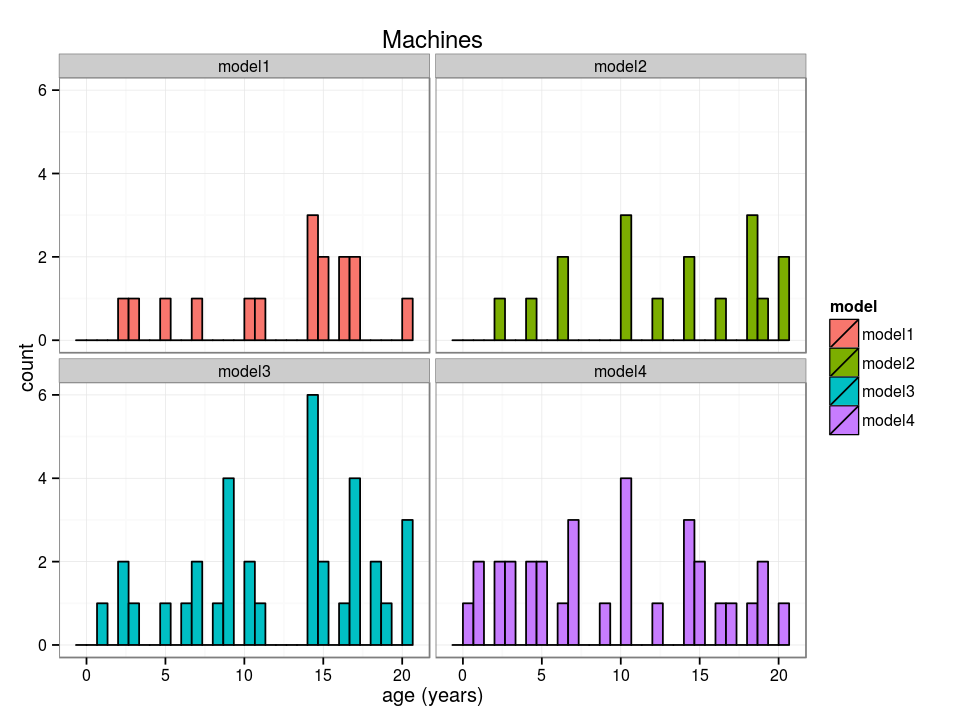

In [9]:
options(repr.plot.width = 8, repr.plot.height = 6)
ggplot(machines, aes(x = age, fill = model)) + 
    geom_histogram(color = "black") + 
    labs(title = "Machines", x = "age (years)") +
    facet_wrap(~model)

### Failures

These are the records of machine failures. Each record has a date and time and machine ID.

In [12]:

# format datetime and failure fields
failures$datetime <- as.POSIXct(failures$datetime,
                                format="%m/%d/%Y %I:%M:%S %p", 
                                tz="UTC")


cat("Total number of failures:", nrow(failures))
failures[c(1:5, nrow(failures)-4:0),]

Total number of failures: 719

,datetime,machineID
1,2015-01-05 06:00:00,1
2,2015-03-06 06:00:00,1
3,2015-04-20 06:00:00,1
4,2015-06-19 06:00:00,1
5,2015-09-02 06:00:00,1
715,2015-11-29 06:00:00,99
716,2015-12-14 06:00:00,99
717,2015-02-12 06:00:00,100
718,2015-09-10 06:00:00,100
719,2015-12-09 06:00:00,100


[Back to top](#Modelling-Guide-for-Predictive-Maintenance)

# Exercise 2 - Feature Engineering

The idea of feature engineering is to conceptually describe and abstract a machineâs health condition at a given time using historical data that was collected up to that point in time. The end result is a training/validation data set created by combining historical data records - in our case: telemetry, errors, failures, and machine properties.



In [11]:
features <- download.datasets(ws, name = "features")
telemetryfeat <- download.datasets(ws, name = "telemetryfeat")
errorfeat <- download.datasets(ws, name = "errorfeat")
unlabeledfeatures <- download.datasets(ws, name = "unlabeledfeatures")


# format datetime field which comes in as.character
# telemetry$datetime <- as.POSIXct(telemetry$datetime,
#                                 format="%m/%d/%Y %I:%M:%S %p",
#                                 tz="UTC")

cat("Total Number of features records:", nrow(features))
head(features,10)


Total Number of features records: 291300

datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,error1count,error2count,error3count,error4count,error5count,model,age,failure
2015-01-02T05:00:00Z,1,169.7338,445.1799,96.79711,40.38516,11.23312,48.71739,10.079880,5.853209,0,0,0,0,0,model3,18,FALSE
2015-01-02T08:00:00Z,1,170.5257,443.9068,97.66725,39.78667,12.59195,46.93028,9.406795,6.098173,0,0,0,0,0,model3,18,FALSE
2015-01-02T11:00:00Z,1,170.0497,446.4613,96.90616,40.01651,13.27734,42.83678,9.071472,5.481724,0,0,0,0,0,model3,18,FALSE
2015-01-02T14:00:00Z,1,170.3420,447.3553,96.22952,39.92196,13.81716,42.80863,8.256794,5.862312,0,0,0,0,0,model3,18,FALSE
2015-01-02T17:00:00Z,1,170.0606,452.1634,96.35744,39.99047,14.79287,42.52529,8.669605,5.907157,0,0,0,0,0,model3,18,FALSE
2015-01-02T20:00:00Z,1,169.3693,453.3362,98.04201,39.53167,15.67479,41.68962,10.607947,6.205887,0,0,0,0,0,model3,18,FALSE
2015-01-02T23:00:00Z,1,169.7958,446.8327,98.45461,39.27165,15.74215,38.80027,11.679314,5.579524,0,0,0,0,0,model3,18,FALSE
2015-01-03T02:00:00Z,1,170.1623,450.2210,100.88052,38.83814,15.80177,40.49000,11.323930,5.565239,0,0,0,0,0,model3,18,FALSE
2015-01-03T05:00:00Z,1,170.3569,454.2429,100.78767,38.47183,15.03377,40.85861,11.384920,5.121860,0,0,0,0,0,model3,18,FALSE
2015-01-03T08:00:00Z,1,169.8592,462.4668,100.40906,40.20433,13.95316,44.26913,10.765817,6.023521,1,0,0,0,0,model3,18,FALSE



## Step 1 -  Lag Features from Telemetry

Telemetry data almost always comes with time-stamps which makes it suitable for calculating lagging features. A common method is to pick a window size for the lag features to be created and compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over the lag window. In this exercise, we want to calculate rolling mean and standard deviation of the telemetry data over the last 24 hour lag window, calculated for every 3 hours.


![Rolling aggregates](https://raw.githubusercontent.com/Microsoft/AMLWorkshop/master/Images/rolling-aggregate-features.png)


In [13]:
                               
cat("Total Number of features records:", nrow(telemetryfeat))
head(telemetryfeat,10)


Total Number of features records: 291300

datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd
2015-01-02T05:00:00Z,1,169.7338,445.1799,96.79711,40.38516,11.23312,48.71739,10.079880,5.853209
2015-01-02T08:00:00Z,1,170.5257,443.9068,97.66725,39.78667,12.59195,46.93028,9.406795,6.098173
2015-01-02T11:00:00Z,1,170.0497,446.4613,96.90616,40.01651,13.27734,42.83678,9.071472,5.481724
2015-01-02T14:00:00Z,1,170.3420,447.3553,96.22952,39.92196,13.81716,42.80863,8.256794,5.862312
2015-01-02T17:00:00Z,1,170.0606,452.1634,96.35744,39.99047,14.79287,42.52529,8.669605,5.907157
2015-01-02T20:00:00Z,1,169.3693,453.3362,98.04201,39.53167,15.67479,41.68962,10.607947,6.205887
2015-01-02T23:00:00Z,1,169.7958,446.8327,98.45461,39.27165,15.74215,38.80027,11.679314,5.579524
2015-01-03T02:00:00Z,1,170.1623,450.2210,100.88052,38.83814,15.80177,40.49000,11.323930,5.565239
2015-01-03T05:00:00Z,1,170.3569,454.2429,100.78767,38.47183,15.03377,40.85861,11.384920,5.121860
2015-01-03T08:00:00Z,1,169.8592,462.4668,100.40906,40.20433,13.95316,44.26913,10.765817,6.023521




### Task

- Use your preferred scripting language to calculate telemetry lag features - mean and standard deviation - over the last 24 hour lag windows, calculated for every 3 hours. Hint - if you use R look at the 'zoo' package.
- Embed your script into an AML workflow, similarly to the below example

![Telemetry feature](https://github.com/Microsoft/AMLWorkshop/blob/master/Images/Lab1-step1.PNG?raw=true)



## Step 2 - Lag Features from Errors

Similar to telemetry, errors also come with time-stamps. However, unlike telemetry that had numerical values, errors have categorical values denoting the type of error that occured at a time-stamp. In this case, aggregating methods such as averaging does not apply. Counting the different categories is a more viable approach where  lagging counts of different types of errors that occured in the lag window are calculated. Below we create such lagging counts from the errors received.

In [14]:

cat("Total Number of features records:", nrow(errorfeat))
head(errorfeat,10)

Total Number of features records: 291300

datetime,machineID,error1count,error2count,error3count,error4count,error5count
2015-01-02T05:00:00Z,1,0,0,0,0,0
2015-01-02T08:00:00Z,1,0,0,0,0,0
2015-01-02T11:00:00Z,1,0,0,0,0,0
2015-01-02T14:00:00Z,1,0,0,0,0,0
2015-01-02T17:00:00Z,1,0,0,0,0,0
2015-01-02T20:00:00Z,1,0,0,0,0,0
2015-01-02T23:00:00Z,1,0,0,0,0,0
2015-01-03T02:00:00Z,1,0,0,0,0,0
2015-01-03T05:00:00Z,1,0,0,0,0,0
2015-01-03T08:00:00Z,1,1,0,0,0,0




### Task

- Use your preferred scripting language to calculate error lag features - count of different error categories - over the last 24 hour lag windows, calculated for every 3 hours. Hints:
   - if you use R look at the 'zoo' package.
   - you may need both telemetry and errors data sets to make sure that the time windows are aligned properly

- Enhance your AML workflow, similarly to the below example




![Error features](https://github.com/Microsoft/AMLWorkshop/blob/master/Images/Lab1-step2.PNG?raw=true)

## Step 3 - Join machine info with telemetry and error features

The machine features are used directly as  they hold descriptive information about the type of the machines and their ages which is the years in service. 


In [15]:

cat("Total Number of features records:", nrow(unlabeledfeatures))
head(unlabeledfeatures,10)


Total Number of features records: 291300

datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,error1count,error2count,error3count,error4count,error5count,model,age
2015-01-02T05:00:00Z,1,169.7338,445.1799,96.79711,40.38516,11.23312,48.71739,10.079880,5.853209,0,0,0,0,0,model3,18
2015-01-02T08:00:00Z,1,170.5257,443.9068,97.66725,39.78667,12.59195,46.93028,9.406795,6.098173,0,0,0,0,0,model3,18
2015-01-02T11:00:00Z,1,170.0497,446.4613,96.90616,40.01651,13.27734,42.83678,9.071472,5.481724,0,0,0,0,0,model3,18
2015-01-02T14:00:00Z,1,170.3420,447.3553,96.22952,39.92196,13.81716,42.80863,8.256794,5.862312,0,0,0,0,0,model3,18
2015-01-02T17:00:00Z,1,170.0606,452.1634,96.35744,39.99047,14.79287,42.52529,8.669605,5.907157,0,0,0,0,0,model3,18
2015-01-02T20:00:00Z,1,169.3693,453.3362,98.04201,39.53167,15.67479,41.68962,10.607947,6.205887,0,0,0,0,0,model3,18
2015-01-02T23:00:00Z,1,169.7958,446.8327,98.45461,39.27165,15.74215,38.80027,11.679314,5.579524,0,0,0,0,0,model3,18
2015-01-03T02:00:00Z,1,170.1623,450.2210,100.88052,38.83814,15.80177,40.49000,11.323930,5.565239,0,0,0,0,0,model3,18
2015-01-03T05:00:00Z,1,170.3569,454.2429,100.78767,38.47183,15.03377,40.85861,11.384920,5.121860,0,0,0,0,0,model3,18
2015-01-03T08:00:00Z,1,169.8592,462.4668,100.40906,40.20433,13.95316,44.26913,10.765817,6.023521,1,0,0,0,0,model3,18


### Task

- Merge all the feature data sets we created earlier to get the final feature matrix:
  - Hint. You can use the *Join Data* shape to perform joint operations
  

## Step 4 - Label Construction

When using classification for predicting failure due to a problem, labeling is done by taking a time window  prior to the failure of an asset and labeling the feature records that fall into that window as about to fail due to a problem while labeling all other records as normal. This time window should be picked according to the business case where in some situations it may be enough to predict failures hours in advance while in others days or weeks maybe needed to allow for the arrival of parts to be replaced as an example.

The prediction problem for this example scenerio is to estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 24 hours due to a  component failure. In the following, labelling is done by labeling all the feature records that fall into the 24 hours window before a failure as TRUE.The rest of the records are labeled as FALSE indicating, there is no failure within the next 24 hours.


In [16]:

cat("Total Number of features records:", nrow(features))
head(features,10)

Total Number of features records: 291300

datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,error1count,error2count,error3count,error4count,error5count,model,age,failure
2015-01-02T05:00:00Z,1,169.7338,445.1799,96.79711,40.38516,11.23312,48.71739,10.079880,5.853209,0,0,0,0,0,model3,18,FALSE
2015-01-02T08:00:00Z,1,170.5257,443.9068,97.66725,39.78667,12.59195,46.93028,9.406795,6.098173,0,0,0,0,0,model3,18,FALSE
2015-01-02T11:00:00Z,1,170.0497,446.4613,96.90616,40.01651,13.27734,42.83678,9.071472,5.481724,0,0,0,0,0,model3,18,FALSE
2015-01-02T14:00:00Z,1,170.3420,447.3553,96.22952,39.92196,13.81716,42.80863,8.256794,5.862312,0,0,0,0,0,model3,18,FALSE
2015-01-02T17:00:00Z,1,170.0606,452.1634,96.35744,39.99047,14.79287,42.52529,8.669605,5.907157,0,0,0,0,0,model3,18,FALSE
2015-01-02T20:00:00Z,1,169.3693,453.3362,98.04201,39.53167,15.67479,41.68962,10.607947,6.205887,0,0,0,0,0,model3,18,FALSE
2015-01-02T23:00:00Z,1,169.7958,446.8327,98.45461,39.27165,15.74215,38.80027,11.679314,5.579524,0,0,0,0,0,model3,18,FALSE
2015-01-03T02:00:00Z,1,170.1623,450.2210,100.88052,38.83814,15.80177,40.49000,11.323930,5.565239,0,0,0,0,0,model3,18,FALSE
2015-01-03T05:00:00Z,1,170.3569,454.2429,100.78767,38.47183,15.03377,40.85861,11.384920,5.121860,0,0,0,0,0,model3,18,FALSE
2015-01-03T08:00:00Z,1,169.8592,462.4668,100.40906,40.20433,13.95316,44.26913,10.765817,6.023521,1,0,0,0,0,model3,18,FALSE



### Task

- Use your preferred scripting language to properly label the feature set
- Enhance the AML workflow to include the labelling operation
- Hint. The final workflow could look like the following example

![Final labeled features](https://github.com/Microsoft/AMLWorkshop/blob/master/Images/Lab1%20-%20step4.PNG?raw=true)


# Exercise 2 - Modeling

In this exercise, we will use a dataset engineered in the previous steps to develop, evaluate and select a binary classification model for predicting machine failures. 

## Step 1 - Preparing training, validation, and testing data sets

When working with data that comes with time-stamps such as telemetry and errors as in this example, splitting of data into training, validation and test sets should be performed carefully to prevent overestimating the performance of the models. In predictive maintenance, the features are usually generated using laging aggregates and consecutive examples that fall into the same time window  may have similar feature values in that window. If a random splitting of training and testing is used, it is possible for some portion of these similar examples that are in the same window to be selected for training and the other portion to leak into the testing data. Also, it is possible for training examples to be ahead of time than validation and testing examples when data is randomly split. However, predictive models should be trained on historical data and valiadted and tested on future data. Due to these problems, validation and testing based on random sampling may provide overly optimistic results. Since random sampling is not a viable approach here, cross validation methods that rely on random samples such as k-fold cross validation is not useful either. 

For predictive maintenance problems, a time-dependent spliting strategy is often a better approach to estimate performance which is done by validating and testing on examples that are later in time than the training examples. For a time-dependent split, a point in time is picked and model is trained on examples up to that point in time, and validated on the examples after that point assuming that the future data after the splitting point is not known. However, this effects the labelling of features falling into the labelling window right before the split as it is assumed that failure information is not known beyond the splitting cut-off. Due to that, those feature records can not be labeled and will not be used. This also prevents the leaking problem at the splitting point.




### Task

Split the data set into three partitions: training, validation, and testing using the following time periods:
- Training - before 2015-06-30
- Validation - between (not including) 2015-06-30 and 2015-09-30
- Testing - after 2015-10-01

Notice that 2015-06-30 and 2015-09-30 splitting dates should be excluded from the partitions to avoid leaking problems. 

Look at the following flow for hints

![Data splitting](https://github.com/Microsoft/AMLWorkshop/blob/master/Images/Lab2-step1-1.PNG?raw=true)

![Data splitting](https://github.com/Microsoft/AMLWorkshop/blob/master/Images/Lab2-step1-2.PNG?raw=true)


## Step 2 - Initial model training and evaluation

There are many different strategies for selecting the best model for a task at hand. In this lab we will start by training a simple and often adequate logistic regression model. We will use this model as a baseline for comparison with other more expressive models in the later steps of the exercise.

In predictive maintenance, machine failures are usually rare occurrences in the lifetime of the assets compared to normal operation. This causes an imbalance in the label distribution which usually causes poor performance as algorithms tend to classify majority class examples better at the expense of minority class examples as the total misclassification error is much improved when majority class is labeled correctly. This causes low recall rates although accuracy can be high and becomes a larger problem when the cost of false alarms to the business is very high. To help with this problem, sampling techniques such as oversampling of the minority examples are usually used along with more sophisticated techniques. Some of these techniques are briefly covered in the optional lab at the end of this guide.

In this lab we will focus on selecting and optimizing the right performance metric to properly address the class imbalance problem. It is important to look at evaluation metrics other than accuracy alone and compare those metrics to the baseline metrics which are computed when random chance is used to make predictions rather than a machine learning model. The metric of choice for our exercise is *recall*.

### Task

- Evolve the AML workflow to add training steps for a binary classification regression model
- Use the following flow as a template



![Training](https://github.com/Microsoft/AMLWorkshop/blob/master/Images/Lab2-step2.PNG?raw=true)


## Step 3 - Hyper-parameter tuning

Most learning algorithm can be fine-tuned by adjusting a set hyper-parameters. The hyper-parameters constrain the model capacity and guide the optimization procedure allowing to find an optimal balance between underfitting and overfitting.

In our case we are looking for the combination of parameters that will yield the highest recall. 

### Task

- Read about the *Tune Model Hyperparameters* shape
- Enhance the workflow to find an optimal combination of logistics regression hyper-parameters using *recall* as an optimization target
- Use the following flow as a template


![Hyper-parameter tuning](https://github.com/Microsoft/AMLWorkshop/blob/master/Images/Lab2-step3.PNG?raw=true)

## Step 4 - Training and tuning a random forest model

In this step we will train and fine tune an alternative model - random forest. 

A major limitation of logistic regression is that it can only learn a linear decision boundry. If our problem is non-linear logistic regression will underfit as it does not have enough capacity to approximate the real decision boundry.


### Task
- Read about a decision forest algorithm and its hyper-parameters
- Enhance the workflow to train and tune its hyper-parameters. Use the above flow as a template



## Step 5 - Retraining the random forest on a full dataset with optimal hyper-parameters


After reviewing the performance metrics of the random forest model it does have a much higher recall than the logistics regression model. We can conclude that this model is better in approximating the pattern in our data.

The next step is to retrain the model with the most optimal set of parameters - discovered in the previous step - and with a full data set - combined training and validation partitions from the previous step. 

This is the common approach used to maximize the use of available training data. After the training is completed we test the model with a testing data set to obtain the final performance estimates.


### Task

- Enhance the workflow to implement the procedure described above



# Exercise 3 - Model Deployment


### Task

- Follow the instructor's model deployment walk-through

# Lab Cheat Sheet

## Exercise 1

### Step 1 - Engineer telemetry features

In [17]:
# calculate the rolling mean and rolling standard deviation 
# on the last 24 hour lag window (width=3), for every 3 hours (by=3)
# for each machine ID.
telemetryfeat <- telemetry %>%
    arrange(machineID, datetime) %>% 
    group_by(machineID) %>%
    mutate(voltmean = rollapply(volt, width = 24, FUN = mean, align = "right", fill = NA, by = 3),
           rotatemean = rollapply(rotate, width = 24, FUN = mean, align = "right", fill = NA, by = 3),
           pressuremean = rollapply(pressure, width = 24, FUN = mean, align = "right", fill = NA, by = 3),
           vibrationmean = rollapply(vibration, width = 24, FUN = mean, align = "right", fill = NA, by = 3),
           voltsd = rollapply(volt, width = 24, FUN = sd, align = "right", fill = NA, by = 3),
           rotatesd = rollapply(rotate, width = 24, FUN = sd, align = "right", fill = NA, by = 3),
           pressuresd = rollapply(pressure, width = 24, FUN = sd, align = "right", fill = NA, by = 3),
           vibrationsd = rollapply(vibration, width = 24, FUN = sd, align = "right", fill = NA, by = 3)) %>%
    select(datetime, machineID, voltmean, rotatemean, pressuremean, vibrationmean, 
           voltsd, rotatesd, pressuresd, vibrationsd ) %>%
    filter(!is.na(voltmean), !is.na(voltsd)) %>% 
    ungroup()




Verify results

In [18]:

cat("Number of rows:", nrow(telemetryfeat))
head(telemetryfeat)

Number of rows: 291300

datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd
2015-01-02 05:00:00,1,169.7338,445.1799,96.79711,40.38516,11.23312,48.71739,10.079880,5.853209
2015-01-02 08:00:00,1,170.5257,443.9068,97.66725,39.78667,12.59195,46.93028,9.406795,6.098173
2015-01-02 11:00:00,1,170.0497,446.4613,96.90616,40.01651,13.27734,42.83678,9.071472,5.481724
2015-01-02 14:00:00,1,170.3420,447.3553,96.22952,39.92196,13.81716,42.80863,8.256794,5.862312
2015-01-02 17:00:00,1,170.0606,452.1634,96.35744,39.99047,14.79287,42.52529,8.669605,5.907157
2015-01-02 20:00:00,1,169.3693,453.3362,98.04201,39.53167,15.67479,41.68962,10.607947,6.205887


### Step 2 - Engineer error features

In [19]:
# create a column for each error type
errorcount <- errors %>% select(datetime, machineID, errorID) %>% 
  mutate(error1 = as.integer(errorID == "error1"), 
         error2 = as.integer(errorID == "error2"),
         error3 = as.integer(errorID == "error3"),
         error4 = as.integer(errorID == "error4"),
         error5 = as.integer(errorID == "error5"))

# sum the duplicate errors in an hour
errorcount <- errorcount %>% 
  group_by(machineID,datetime)%>%
  summarise(error1sum = sum(error1), 
            error2sum = sum(error2), 
            error3sum = sum(error3), 
            error4sum = sum(error4), 
            error5sum = sum(error5)) %>%
  ungroup()

# align errors with telemetry datetime field
errorfeat <- telemetry %>% 
    select(datetime, machineID) %>%
    left_join(errorcount, by = c("datetime", "machineID"))

# replace missing values
errorfeat[is.na(errorfeat)] <- 0

# count the number of errors of different types in the last 24 hours,  for every 3 hours
errorfeat <- errorfeat %>% 
    arrange(machineID, datetime) %>%
    group_by(machineID) %>%
    mutate(error1count = rollapply(error1sum, width = 24, FUN = sum, align = "right", fill = NA, by = 3),
           error2count = rollapply(error2sum, width = 24, FUN = sum, align = "right", fill = NA, by = 3),
           error3count = rollapply(error3sum, width = 24, FUN = sum, align = "right", fill = NA, by = 3),
           error4count = rollapply(error4sum, width = 24, FUN = sum, align = "right", fill = NA, by = 3),
           error5count = rollapply(error5sum, width = 24, FUN = sum, align = "right", fill = NA, by = 3)) %>%
    select(datetime, machineID, error1count, error2count, error3count, error4count, error5count) %>%
    filter(!is.na(error1count)) %>% 
    ungroup()





Verify results

In [20]:
cat("Number of rows:", nrow(errorfeat))
head(errorfeat,10)

Number of rows: 291300

datetime,machineID,error1count,error2count,error3count,error4count,error5count
2015-01-02 05:00:00,1,0,0,0,0,0
2015-01-02 08:00:00,1,0,0,0,0,0
2015-01-02 11:00:00,1,0,0,0,0,0
2015-01-02 14:00:00,1,0,0,0,0,0
2015-01-02 17:00:00,1,0,0,0,0,0
2015-01-02 20:00:00,1,0,0,0,0,0
2015-01-02 23:00:00,1,0,0,0,0,0
2015-01-03 02:00:00,1,0,0,0,0,0
2015-01-03 05:00:00,1,0,0,0,0,0
2015-01-03 08:00:00,1,1,0,0,0,0


### Step 3 - Join machine info with telemetry and error features



![Error features](https://github.com/Microsoft/AMLWorkshop/blob/master/Images/Lab1-step3.PNG?raw=true)

In [21]:
# telemetry and error features have the same datetime 
finalfeat <- data.frame(telemetryfeat, errorfeat[,-c(1:2)])

# merge with machine features 
finalfeat <- finalfeat %>% 
    left_join(machines, by = c("machineID"))




Verify results

In [22]:
head(finalfeat, 10)
cat("The final set of features are:",paste0(names(finalfeat), ","))

cat("Number of rows:", nrow(finalfeat))

datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,error1count,error2count,error3count,error4count,error5count,model,age
2015-01-02 05:00:00,1,169.7338,445.1799,96.79711,40.38516,11.23312,48.71739,10.079880,5.853209,0,0,0,0,0,model3,18
2015-01-02 08:00:00,1,170.5257,443.9068,97.66725,39.78667,12.59195,46.93028,9.406795,6.098173,0,0,0,0,0,model3,18
2015-01-02 11:00:00,1,170.0497,446.4613,96.90616,40.01651,13.27734,42.83678,9.071472,5.481724,0,0,0,0,0,model3,18
2015-01-02 14:00:00,1,170.3420,447.3553,96.22952,39.92196,13.81716,42.80863,8.256794,5.862312,0,0,0,0,0,model3,18
2015-01-02 17:00:00,1,170.0606,452.1634,96.35744,39.99047,14.79287,42.52529,8.669605,5.907157,0,0,0,0,0,model3,18
2015-01-02 20:00:00,1,169.3693,453.3362,98.04201,39.53167,15.67479,41.68962,10.607947,6.205887,0,0,0,0,0,model3,18
2015-01-02 23:00:00,1,169.7958,446.8327,98.45461,39.27165,15.74215,38.80027,11.679314,5.579524,0,0,0,0,0,model3,18
2015-01-03 02:00:00,1,170.1623,450.2210,100.88052,38.83814,15.80177,40.49000,11.323930,5.565239,0,0,0,0,0,model3,18
2015-01-03 05:00:00,1,170.3569,454.2429,100.78767,38.47183,15.03377,40.85861,11.384920,5.121860,0,0,0,0,0,model3,18
2015-01-03 08:00:00,1,169.8592,462.4668,100.40906,40.20433,13.95316,44.26913,10.765817,6.023521,1,0,0,0,0,model3,18


The final set of features are: datetime, machineID, voltmean, rotatemean, pressuremean, vibrationmean, voltsd, rotatesd, pressuresd, vibrationsd, error1count, error2count, error3count, error4count, error5count, model, age,Number of rows: 291300

[Back to top](#Modelling-Guide-for-Predictive-Maintenance)

### Step 4 Label Construction



In [23]:
# left join final features with failures on machineID then mutate a column for datetime difference
# filter date difference for the prediction horizon which is 24 hours
labeledfailures <- finalfeat %>%
    select(datetime, machineID) %>%
    left_join(failures, by = c("machineID")) %>%
    mutate(failure = difftime(datetime.y, datetime.x, units = "hours") >= 0 &
                 difftime(datetime.y, datetime.x, units = "hours") <= 24) %>%
    filter(failure == TRUE) %>%
    select(datetime = datetime.x, machineID, failure)

features <- left_join(finalfeat, labeledfailures, by= c("datetime", "machineID"))
features$failure[is.na(features$failure)]<-FALSE



Verify results

In [24]:
head(features, 5)
cat("Number of rows:", nrow(features))

features %>% group_by(failure) %>% count(failure)

datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,error1count,error2count,error3count,error4count,error5count,model,age,failure
2015-01-02 05:00:00,1,169.7338,445.1799,96.79711,40.38516,11.23312,48.71739,10.079880,5.853209,0,0,0,0,0,model3,18,FALSE
2015-01-02 08:00:00,1,170.5257,443.9068,97.66725,39.78667,12.59195,46.93028,9.406795,6.098173,0,0,0,0,0,model3,18,FALSE
2015-01-02 11:00:00,1,170.0497,446.4613,96.90616,40.01651,13.27734,42.83678,9.071472,5.481724,0,0,0,0,0,model3,18,FALSE
2015-01-02 14:00:00,1,170.3420,447.3553,96.22952,39.92196,13.81716,42.80863,8.256794,5.862312,0,0,0,0,0,model3,18,FALSE
2015-01-02 17:00:00,1,170.0606,452.1634,96.35744,39.99047,14.79287,42.52529,8.669605,5.907157,0,0,0,0,0,model3,18,FALSE


Number of rows: 291300

failure,n
FALSE,285705
TRUE,5595


![Final labeled features](https://github.com/Microsoft/AMLWorkshop/blob/master/Images/Lab1%20-%20step4.PNG?raw=true)

## Exercise 2

### Step 1 - Data splitting

![Data splitting](https://github.com/Microsoft/AMLWorkshop/blob/master/Images/Lab2-step1.PNG?raw=true)

### Step 4 - Model selection

![Data splitting](https://github.com/Microsoft/AMLWorkshop/blob/master/Images/Lab2-step4.PNG?raw=true)

### Step 5 - Final model training and evaluation

![Final training](https://github.com/Microsoft/AMLWorkshop/blob/master/Images/Lab2-step5.PNG?raw=true)

[Back to top](#Modelling-Guide-for-Predictive-Maintenance)

## Summary

In this notebook,  the steps of implementing a predictive maintenance model is provided using an example scenario where the goal is to predict failures due to certain components of a machine. Typical steps of predictive maintenance such as feature engineering, labelling, training and evaluation are explained using the example data sets. Predictive models are built both using R packages and Azure Machine Learning Studio.

[Back to top](#Modelling-Guide-for-Predictive-Maintenance)